# <center>Проект: предсказание токсичности соединений</center>

**<u>Дано:</u>**

* `train.csv` – данные для обучения
* `test_only_smiles.csv` – данные для предсказания

**<u>Необходимо:</u>**

1) Проанализировать данные + визуализация
2) Предобработать данные, чтобы улучшить качество модели
3) Обучить модель и провалидировать ее (метрика: RMSE)
4) Проверить модель на *test* данных и прислать результаты вместе с ноутбуком

## <center>Библиотеки и загрузка данных</center>

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
train.head()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


## <center>Анализ данных</center>

In [10]:
# Посмотрим информацию о датасете
train.info()

# И описательную статистику
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


,activity
count,759.000000
mean,40.691304
std,36.150662
min,-38.300000
25%,10.750000
50%,30.100000
75%,69.550000
max,111.000000


In [11]:
# Избавимся от дубликатов
train_copy = train.copy()
train_copy.drop_duplicates()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2
...,...,...
754,CC1=CC2=CC=CN=C2C=C1,43.1
755,C12CC[C@@](O)(C#C)[C@@]1(C)CCC3C4CCC(=O)C=C4CCC23,15.8
756,CCCCNS(=O)(=O)C1=CC=CC=C1,17.8
757,NC1=C(Cl)C(Cl)=NC(C(O)=O)=C1Cl,55.1


В нашем датасете всего два столбца:
1) Категориальный признак `SMILES` (тип *object*), содержащий химическую формулу, записанную в текстовом формате.
2) Наш *target* `activity` (тип *float64*), токсичность вещества, которая варьирует от -38.3 до 111.0 в процентах. 

Пропусков и дубликатов в датасете нет.

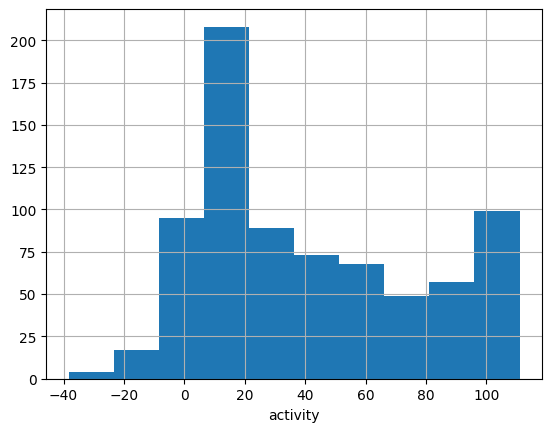

In [17]:
import matplotlib.pyplot as plt

# Визуализация значений 'activity' 
train_copy['activity'].hist()
plt.xlabel('activity')
plt.show()

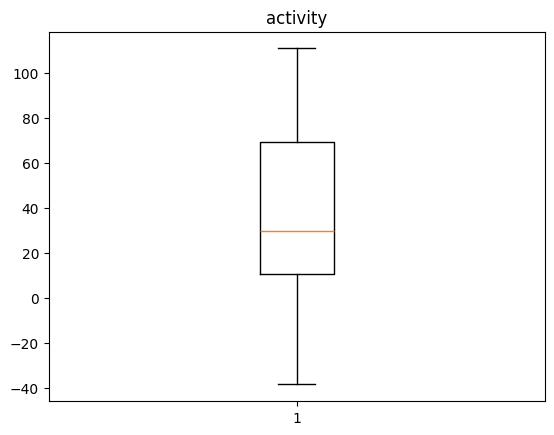

In [16]:
# Boxplot для 'activity'
plt.boxplot(train_copy['activity'])
plt.title('activity')
plt.show()

Визуализация подтверждает информацию, которую мы получили ранее:

* Значения варьируют от -38.3 до 111.0;
* Медиана 30.1.


Также на BoxPlot видно, что нет выбросов.

## <center>Предобработка данных</center>

In [18]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [19]:
# Функция из ноутбука
# Один из способов превратить молекулы в числа – это fingerprints
def smiles_to_fp(smiles):
    '''Convert SMILES to Morgan fingerprints'''
    return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

In [27]:
X_train = smiles_to_fp(train_copy.SMILES)

[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerator
[14:30:42] DEPRECATION WARNING: please use MorganGenerat

In [28]:
X_train.shape

(759, 1024)

In [29]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

* Понизить размерность
* Сгенерировать новые признаки
* Попробовать кластеризацию